<a href="https://colab.research.google.com/github/arnabbiswas66/multimodal-fake-news-classifier/blob/main/Experiments/Twitter_image_only_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNetV2 B3

In [1]:
from tensorflow.python.platform.tf_logging import warn
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import re
from os import listdir
import shutil
import glob
import random
import matplotlib.pyplot as plt
import tensorflow_hub as hub
tf.get_logger().setLevel('ERROR')
import warnings

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BASE_SAVE_LOCATION = "/content/drive/MyDrive/multimodal-news"
CHECKPOINT_FILEPATH = '/content/drive/MyDrive/multimodal-news/twitter-models/'

## Load the dataframes

In [4]:
#Load training df
train_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/twitter-train.pickle")
test_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/twitter-test.pickle")
print(train_df_model.shape, test_df_model.shape)

(14258, 3) (1923, 3)


# Data input pipeline

In [5]:
def dataframe_to_dataset(dataframe):
    columns = ['image_1', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [6]:
resize = (224, 224)

In [7]:
def preprocess_image(image_path):
  extension = tf.strings.split(image_path,'.')[-1]
  image = tf.io.read_file(image_path)
  if extension == b"gif":
    image = tf.io.decode_image(image, 3, expand_animations=False)
  elif extension == b"png":
    image = tf.image.decode_png(image, 3)
  else:
    image = tf.image.decode_jpeg(image, 3)
  image = tf.image.resize(image, resize)
  return image

In [8]:
def preprocess_text_and_image(sample):
  image_1 = preprocess_image(sample["image_1"])
  return {"image_1": image_1}

In [9]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [10]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [11]:
train_ds = prepare_dataset(train_df_model)
test_ds = prepare_dataset(test_df_model, False)

## Model Building

### Projection

In [12]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings


### Vision encoder

In [13]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.EfficientNetV2B3(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings = resnet_v2(preprocessed_1)
    #embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

## ImageOnly model

In [14]:
def create_image_only_model(
    num_projection_layers=0,
    projection_dims=224,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
    attention=False
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
   # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    
    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1])
    vision_projections = keras.layers.Dropout(dropout_rate)(vision_projections)
    
    outputs = keras.layers.Dense(1, activation="sigmoid")(vision_projections)
    return keras.Model([image_1], outputs)

In [15]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [16]:
image_only_model = create_image_only_model(attention=False, num_projection_layers=0, projection_dims=128, dropout_rate=0.0)
image_only_model.summary()

52606240/52606240 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vision_encoder (Functional)  (None, 128)              13127358  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 13,127,487
Trainable params: 196,865
Non-trainable params: 12,930,622
_________________________________________________________________


### Model Training

In [17]:
epochs = 10
batch_size = 32

In [18]:
image_only_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history = image_only_model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
446/446 [==============================] - 135s 245ms/step - loss: 0.4416 - accuracy: 0.7993 - precision: 0.7651 - recall: 0.6010 - val_loss: 0.7684 - val_accuracy: 0.3567 - val_precision: 0.1591 - val_recall: 0.0058
Epoch 2/10
446/446 [==============================] - 46s 103ms/step - loss: 0.3650 - accuracy: 0.8432 - precision: 0.8160 - recall: 0.7025 - val_loss: 0.4285 - val_accuracy: 0.8908 - val_precision: 0.9655 - val_recall: 0.8567
Epoch 3/10
446/446 [==============================] - 45s 101ms/step - loss: 0.3322 - accuracy: 0.8574 - precision: 0.8289 - recall: 0.7378 - val_loss: 0.5863 - val_accuracy: 0.8274 - val_precision: 0.9610 - val_recall: 0.7556
Epoch 4/10
446/446 [==============================] - 46s 103ms/step - loss: 0.3144 - accuracy: 0.8686 - precision: 0.8425 - recall: 0.7600 - val_loss: 0.6396 - val_accuracy: 0.8258 - val_precision: 0.9599 - val_recall: 0.7539
Epoch 5/10
446/446 [==============================] - 45s 101ms/step - loss: 0.2999 - accur

Plot training loss vs testing loss

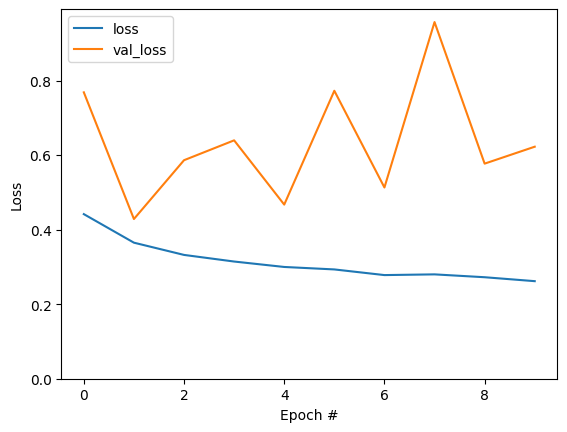

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs testing accuracy

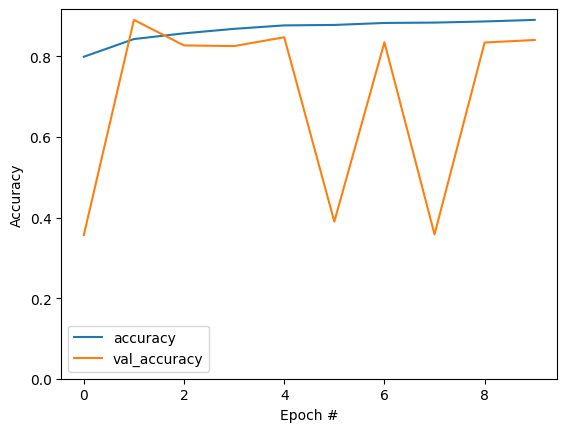

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [21]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

In [22]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [23]:
y_pred = image_only_model.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

61/61 [==============================] - 7s 82ms/step
Accuracy == 0.8408736349453978
F1 == [0.81588448 0.85989011]
Precision == [0.7167019  0.96110542]
Recall == [0.94692737 0.77796189]


# InceptionNet

In [24]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.InceptionV3(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = tf.keras.applications.inception_v3.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    embeddings = resnet_v2(preprocessed_1)
    
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

In [25]:
image_only_model1 = create_image_only_model(attention=False, num_projection_layers=1, projection_dims=128, dropout_rate=0.2)
image_only_model1.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vision_encoder (Functional)  (None, 128)              22081824  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22,081,953
Trainable params: 279,169
Non-trainable params: 21,802,784
_________________________________________________________________


### Model Training

In [26]:
image_only_model1.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history1 = image_only_model1.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
446/446 [==============================] - 48s 90ms/step - loss: 0.0595 - accuracy: 0.9604 - precision: 0.9674 - recall: 0.9265 - val_loss: 4.7167 - val_accuracy: 0.2767 - val_precision: 0.3251 - val_recall: 0.1417
Epoch 2/10
446/446 [==============================] - 36s 80ms/step - loss: 0.0100 - accuracy: 0.9973 - precision: 0.9967 - recall: 0.9953 - val_loss: 4.2505 - val_accuracy: 0.2741 - val_precision: 0.3220 - val_recall: 0.1417
Epoch 3/10
446/446 [==============================] - 36s 81ms/step - loss: 0.0063 - accuracy: 0.9981 - precision: 0.9980 - recall: 0.9965 - val_loss: 4.3631 - val_accuracy: 0.1628 - val_precision: 0.2331 - val_recall: 0.1458
Epoch 4/10
446/446 [==============================] - 36s 81ms/step - loss: 0.0025 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9990 - val_loss: 6.8721 - val_accuracy: 0.2969 - val_precision: 0.3541 - val_recall: 0.1458
Epoch 5/10
446/446 [==============================] - 36s 81ms/step - loss: 0.0045 - accuracy: 0

Plot training loss vs testing loss

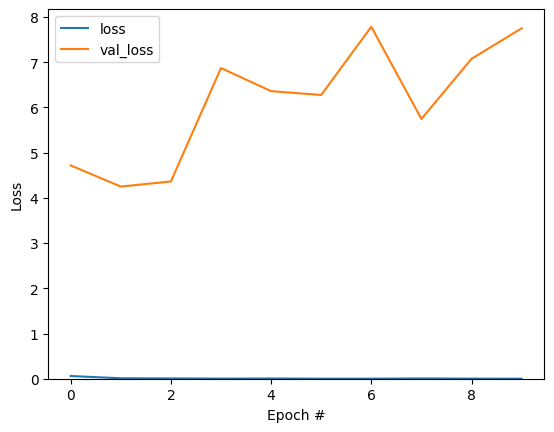

In [27]:
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs testing accuracy

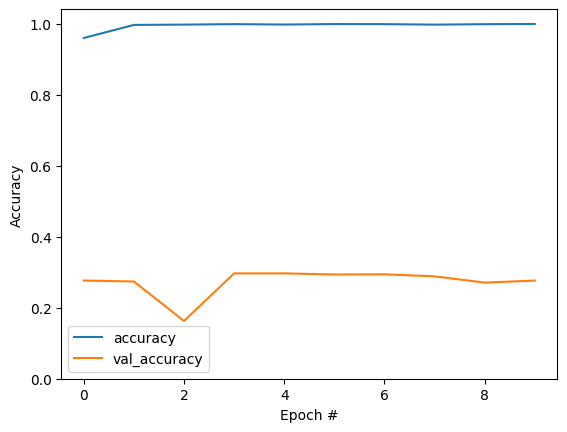

In [28]:
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [29]:
y_pred = image_only_model1.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

61/61 [==============================] - 5s 68ms/step
Accuracy == 0.2766510660426417
F1 == [0.34169427 0.19734564]
Precision == [0.25841088 0.32509506]
Recall == [0.50418994 0.14167357]


# MobileNetV3 Small

In [30]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.MobileNetV3Small(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = tf.keras.applications.mobilenet_v3.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    embeddings = resnet_v2(preprocessed_1)
    
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

In [31]:
image_only_model2 = create_image_only_model(attention=False, num_projection_layers=0, projection_dims=128, dropout_rate=0.0)
image_only_model2.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vision_encoder (Functional)  (None, 128)              1012976   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,013,105
Trainable params: 73,985
Non-trainable params: 939,120
_________________________________________________________________


### Model Training

In [32]:
image_only_model2.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history2 = image_only_model2.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
446/446 [==============================] - 18s 31ms/step - loss: 0.0786 - accuracy: 0.8916 - precision: 0.9044 - recall: 0.7973 - val_loss: 1.5061 - val_accuracy: 0.2283 - val_precision: 0.1646 - val_recall: 0.0563
Epoch 2/10
446/446 [==============================] - 11s 25ms/step - loss: 0.0188 - accuracy: 0.9959 - precision: 0.9945 - recall: 0.9937 - val_loss: 0.9871 - val_accuracy: 0.6989 - val_precision: 0.7329 - val_recall: 0.8186
Epoch 3/10
446/446 [==============================] - 11s 25ms/step - loss: 0.0130 - accuracy: 0.9966 - precision: 0.9957 - recall: 0.9943 - val_loss: 0.9337 - val_accuracy: 0.6505 - val_precision: 0.7128 - val_recall: 0.7423
Epoch 4/10
446/446 [==============================] - 11s 25ms/step - loss: 0.0092 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9949 - val_loss: 0.8030 - val_accuracy: 0.8050 - val_precision: 0.8741 - val_recall: 0.8053
Epoch 5/10
446/446 [==============================] - 11s 25ms/step - loss: 0.0065 - accuracy: 0

Plot training loss vs testing loss

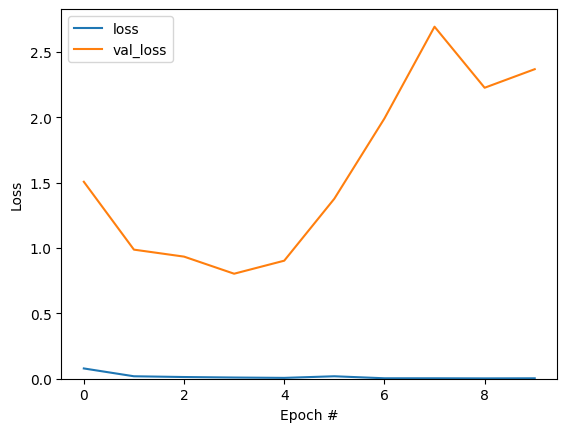

In [33]:
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs testing accuracy

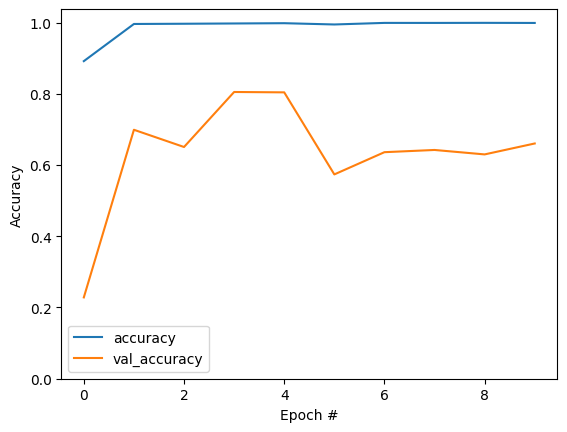

In [34]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [35]:
y_pred = image_only_model2.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

61/61 [==============================] - 2s 20ms/step
Accuracy == 0.6604264170566823
F1 == [0.46343468 0.75161658]
Precision == [0.56287425 0.69479606]
Recall == [0.39385475 0.81855841]
